In [1]:
import os
from enum import Enum

import albumentations as albu
from albumentations.pytorch.functional import img_to_tensor

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision

from sklearn.model_selection import KFold
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision.models import resnet18

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

SEED = 82734
torch.manual_seed(SEED)
np.random.seed(SEED)

DEVICE_NUM = 0

device = torch.device(f'cuda:{DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')

In [3]:
DATA_PATH = '../data/data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TRAIN_IMG_PATH = os.path.join(TRAIN_PATH, 'images')

In [4]:
landmarks = pd.read_csv(os.path.join(TRAIN_PATH, 'landmarks.csv'), delimiter='\t')

images = landmarks['file_name'].values
landmarks = landmarks.iloc[:, 1:].values
landmarks = landmarks.reshape(landmarks.shape[0], -1, 2)

In [5]:
class Mode(Enum):
    train = 1
    test = 2

class LandmarksDataset(Dataset):
    
    def __init__(self, image_dir_path, images, landmarks=None, mode=Mode.train, indices=None, transform=None):
        self.image_dir_path = image_dir_path
        self.images = images
        self.landmarks = landmarks
        self.mode = mode
        self.indices = indices if indices is not None else range(len(images))
        self.transform = transform
        
    def __len__(self):
        return len(self.indices)
    
    def _load_image(self, image):
        img = cv2.imread(os.path.join(self.image_dir_path, image))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    def __getitem__(self, idx):
        index = self.indices[idx]
        image = self._load_image(self.images[index])
        H, W, _ = image.shape
        H, W = torch.FloatTensor([H]), torch.FloatTensor([W])
        if self.mode == Mode.train:
            landmarks = self.landmarks[index]
            if self.transform is not None:
                transformed = self.transform(image=image, keypoints=landmarks)
                return img_to_tensor(transformed['image']), torch.FloatTensor(transformed['keypoints']), H, W
            return img_to_tensor(image), torch.FloatTensor(landmarks), H, W
            
        elif self.mode == Mode.test:
            if self.transform is not None:
                transformed = self.transform(image=image)
                return img_to_tensor(transformed['image']), H, W
            return img_to_tensor(image), H, W
            
        else:
            raise ValueError('unknown mode')

In [6]:
NUM_WORKERS = 10

BATCH_SIZE = 256
CROP_SIZE = 256
N_POINTS = 971

train_transforms = albu.Compose([
    albu.SmallestMaxSize(max_size=CROP_SIZE, interpolation=cv2.INTER_AREA, p=1),
    albu.CenterCrop(height=CROP_SIZE, width=CROP_SIZE, p=1),
    albu.RandomBrightnessContrast(p=0.25),
    albu.ToGray(p=0.1),
    albu.CoarseDropout(p=0.25),
    albu.RGBShift(p=0.1),
    albu.Normalize(p=1)
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

val_transforms = albu.Compose([
    albu.SmallestMaxSize(max_size=CROP_SIZE, interpolation=cv2.INTER_AREA, p=1),
    albu.CenterCrop(height=CROP_SIZE, width=CROP_SIZE, p=1),
    albu.Normalize(p=1),
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

In [7]:
class Model(nn.Module):
    
    def __init__(self, n_points, backbone):
        super().__init__()
        self.n_points = n_points
        self.backbone = backbone
        self.backbone.fc = nn.Linear(backbone.fc.in_features, n_points * 2)

        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.backbone.fc.weight)
        self.backbone.fc.bias.data.fill_(0)
        
    def forward(self, x, h, w):
        N, C, H, W = x.size()
        out = self.backbone(x)
        out = out.view(N, self.n_points, 2).clone()
        return out

In [8]:
MODELS_PATH = '../data/models/'

def validate(model, val_dl, criterion, metric_fn):
    with torch.no_grad():
        model.eval()
        losses = []
        metrics = []
        for images, landmarks, h, w in val_dl:
            images, landmarks = images.to(device), landmarks.to(device)
            out = model(images, h.to(device), w.to(device))
            loss = criterion(out, landmarks)
            metric = metric_fn(torch.round(out), landmarks)

            losses.append(loss.item())
            metrics.append(metric.item())
            
    return np.mean(losses), np.mean(metrics)

def train(model, train_dl, val_dl, criterion, metric_fn, opt, n_epochs, lr_scheduler=None, prefix=''):
    train_loss = []
    train_metric = []
    val_loss = []
    val_metric = []
    
    best_metric = np.inf
    for e in range(n_epochs):
        model.train()
        losses = []
        metrics = []
        pbar = tqdm(train_dl)
        for images, landmarks, h, w in pbar:
            images, landmarks = images.to(device), landmarks.to(device)
            out = model(images, h.to(device), w.to(device))
            loss = criterion(out, landmarks)
            metric = metric_fn(torch.round(out), landmarks)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
            losses.append(loss.item())
            metrics.append(metric.item())
            pbar.set_description('[{}={:.4}]-[{}={:.4}]'.format(
                str(criterion), loss.item(), str(metric_fn), metric.item()
            ))
            
        train_loss.append(np.mean(losses))
        train_metric.append(np.mean(metrics))
        
        val_loss_, val_metric_ = validate(model, val_dl, criterion, metric_fn)
        val_loss.append(val_loss_)
        val_metric.append(val_metric_)
        
        if lr_scheduler is not None:
            lr_scheduler.step()  
            
        if val_metric[-1] < best_metric:
            best_metric = val_metric[-1] 
            with open(os.path.join(MODELS_PATH, f'{prefix}epoch{e + 1}_metric{val_metric[-1]:.4f}.pth', ), "wb") as fp:
                torch.save(model.state_dict(), fp)
            
        print('Iteration {}, train_{}={:.4}, train_{}={:.4}, val_{}={:.4}, val_{}={:.4}'.format(
            e + 1, str(criterion), train_loss[-1], str(metric_fn), train_metric[-1],
            str(criterion), val_loss[-1], str(metric_fn), val_metric[-1]
        ))
               
    return model, (train_loss, train_metric, val_loss, val_metric)

In [9]:
class CosAnnealR(CosineAnnealingWarmRestarts):
    """
    Mostly copied from pytorch code
    """
    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, lr_mult=1, last_epoch=-1):
        super().__init__(optimizer, T_0, T_mult, eta_min, last_epoch)
        self.lr_mult = lr_mult

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        mult = self.lr_mult ** int(self.last_epoch // self.T_i)
        return [self.eta_min + (base_lr * mult - self.eta_min) * (1 + np.cos(np.pi * self.T_cur / self.T_i)) / 2
                for base_lr in self.base_lrs]
    
    def step(self, epoch=None):
        """
        Step could be called after every batch update
        """
        
        if epoch is None and self.last_epoch < 0:
            epoch = 0

        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.T_cur = self.T_cur - self.T_i
                self.T_i = self.T_i * self.T_mult
        else:
            if epoch < 0:
                raise ValueError("Expected non-negative epoch, but got {}".format(epoch))
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                else:
                    n = int(np.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
        self.last_epoch = np.floor(epoch)

        class _enable_get_lr_call:

            def __init__(self, o):
                self.o = o

            def __enter__(self):
                self.o._get_lr_called_within_step = True
                return self

            def __exit__(self, type, value, traceback):
                self.o._get_lr_called_within_step = False
                return self

        with _enable_get_lr_call(self):
            for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
                param_group['lr'] = lr

        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]

### Train

In [10]:
def crossval(images, device, prefix, last_criterion):
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

    for fold_num, (train_indices, val_indices) in enumerate(kf.split(images)):
        prefix = f'{prefix}{fold_num + 1}/'
        print(prefix)
        
        criterion = nn.L1Loss()
        metric = nn.MSELoss()
        model = Model(N_POINTS, resnet18(pretrained=True)).to(device)

        train_dataset = LandmarksDataset(TRAIN_IMG_PATH, images, landmarks, mode=Mode.train, indices=train_indices, 
                                         transform=train_transforms)
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, 
                                      pin_memory=True)

        val_dataset = LandmarksDataset(TRAIN_IMG_PATH, images, landmarks, mode=Mode.train, indices=val_indices, 
                                       transform=val_transforms)
        val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, 
                                    pin_memory=True)
        
        # freeze layers
        for param in list(model.parameters())[:-2]:
            param.requires_grad = False

        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        lr_scheduler = None
        N_EPOCHS = 1 # train 1 epoch with L1 loss
        model, loss = train(
            model, train_dataloader, val_dataloader, criterion, metric, opt, N_EPOCHS, lr_scheduler, prefix)

        criterion = nn.MSELoss() # train 1 epoch with mse loss
        opt = torch.optim.Adam(model.parameters(), lr=1e-3) # reset optimizer
        model, loss = train(
            model, train_dataloader, val_dataloader, criterion, metric, opt, N_EPOCHS, lr_scheduler, prefix)

        # unfreeze layers
        for param in list(model.parameters())[:-2]:
            param.requires_grad = True

        N_EPOCHS = 3
        criterion = nn.L1Loss() # train 3 epochs with L1 Loss
        opt = torch.optim.Adam(model.parameters(), lr=1e-3) # reset optimizer
        model, loss = train(
            model, train_dataloader, val_dataloader, criterion, metric, opt, N_EPOCHS, lr_scheduler, prefix)

        N_EPOCHS = 3
        criterion = nn.MSELoss() # train 3 epochs with MSE Loss
        opt = torch.optim.Adam(model.parameters(), lr=1e-3) # reset optimizer
        model, loss = train(
            model, train_dataloader, val_dataloader, criterion, metric, opt, N_EPOCHS, lr_scheduler, prefix)
        
        N_EPOCHS = 20
        criterion = last_criterion # train 20 epochs with last_criterion loss
        opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
        lr_scheduler = CosAnnealR(opt, T_0=10, eta_min=1e-6, lr_mult=0.9)
        model, loss = train(
            model, train_dataloader, val_dataloader, criterion, metric, opt, N_EPOCHS, lr_scheduler, prefix)

In [11]:
model = crossval(images, device, 'fold_l1_', nn.L1Loss())

In [12]:
model = crossval(images, device, 'fold_mse_', nn.MSELoss())

### Test predict

In [13]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [14]:
def get_scale_coefs(h, w):
    scale = CROP_SIZE / np.min([h, w], axis=0)
    new_h, new_w = np.round(h * scale), np.round(w * scale)
    margin_h, margin_w = (new_h - CROP_SIZE) // 2, (new_w - CROP_SIZE) // 2
    return scale, margin_h, margin_w

In [15]:
def restore_landmarks_batch(landmarks, scale, margin_w, margin_h):
    landmarks[:, :, 0] += margin_w[:, None]
    landmarks[:, :, 1] += margin_h[:, None]
    landmarks /= scale[:, None, None]
    return landmarks

In [16]:
TEST_PATH = os.path.join(DATA_PATH, 'test')
TEST_IMG_PATH = os.path.join(TEST_PATH, 'images')

In [17]:
test_points = pd.read_csv('../data/test_points.csv', delimiter='\t')
test_images = test_points['file_name'].values
test_keypoints_indices = test_points['point_index_list'].apply(
    lambda x: pd.Series(list(map(np.int32, x[1:-1].split(', '))))).values

In [18]:
test_transforms = albu.Compose([
    albu.SmallestMaxSize(max_size=CROP_SIZE, interpolation=cv2.INTER_AREA, p=1),
    albu.CenterCrop(height=CROP_SIZE, width=CROP_SIZE, p=1),
    albu.Normalize(p=1),
])

test_dataset = LandmarksDataset(TEST_IMG_PATH, test_images, mode=Mode.test, indices=range(len(test_images)), 
                                transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, 
                             pin_memory=True)

In [19]:
def predict(model, test_dl):
    preds = np.zeros((len(test_dl.dataset), N_POINTS, 2))
    with torch.no_grad():
        model.eval()
        for i, (images, h, w) in enumerate(test_dl):
            images = images.to(device)
            pred = model(images, h.to(device), w.to(device)).detach().cpu().numpy()
            
            h = h.detach().cpu().numpy().ravel()
            w = w.detach().cpu().numpy().ravel()
            scale, margin_h, margin_w = get_scale_coefs(h, w)
            pred = restore_landmarks_batch(pred, scale, margin_w, margin_h)
            pred[:, :, 0] = np.clip(pred[:, :, 0], 0, np.repeat(w, N_POINTS).reshape(-1, N_POINTS))
            pred[:, :, 1] = np.clip(pred[:, :, 1], 0, np.repeat(h, N_POINTS).reshape(-1, N_POINTS))
            preds[i * test_dl.batch_size: (i + 1) * test_dl.batch_size] = pred
            
    return preds

In [20]:
def make_prediction(model, test_dataloader, model_paths):
    preds = np.zeros((len(test_dataloader.dataset
                         ), N_POINTS, 2))
    for path in model_paths:
        state_dict = torch.load(os.path.join(MODELS_PATH, path))
        model.load_state_dict(state_dict)
        preds += predict(model, test_dataloader)

    return preds / 5

In [21]:
model = Model(N_POINTS, resnet18(pretrained=True)).to(device)

In [22]:
model_l1_1_path = 'fold_l1_1/epoch18_metric5.7313.pth'
model_l1_2_path = 'fold_l1_2/epoch10_metric5.7379.pth'
model_l1_3_path = 'fold_l1_3/epoch10_metric5.6571.pth'
model_l1_4_path = 'fold_l1_4/epoch9_metric5.5714.pth'
model_l1_5_path = 'fold_l1_5/epoch10_metric5.5853.pth'

In [23]:
model_mse_1_path = 'fold_mse_1/epoch8_metric5.8586.pth'
model_mse_2_path = 'fold_mse_2/epoch9_metric5.8440.pth'
model_mse_3_path = 'fold_mse_3/epoch10_metric5.8057.pth'
model_mse_4_path = 'fold_mse_4/epoch9_metric5.7331.pth'
model_mse_5_path = 'fold_mse_5/epoch10_metric5.8186.pth'

In [24]:
preds_l1 = make_prediction(
    model, test_dataloader, (model_l1_1_path, model_l1_2_path, model_l1_3_path, model_l1_4_path, model_l1_5_path))

In [25]:
preds_mse = make_prediction(
    model, test_dataloader, (model_mse_1_path, model_mse_2_path, model_mse_3_path, model_mse_4_path, model_mse_5_path))

In [26]:
preds = (preds_mse + preds_l1) / 2

In [27]:
check_dataset = LandmarksDataset(TEST_IMG_PATH, test_images, mode=Mode.test, indices=range(1000))

imgs = []
for img, h, w in check_dataset:
    imgs.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


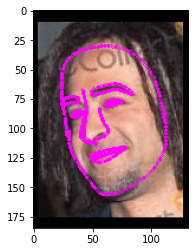

In [28]:
i = np.random.randint(0, len(check_dataset))
image = draw_landmarks(cv2.UMat(np.moveaxis(imgs[i].detach().cpu().numpy(), 0, -1)), preds[i])
plt.imshow(image.get());

In [29]:
filtered_preds = np.zeros((preds.shape[0], 2 * 30))
for i in range(preds.shape[0]):
    filtered_preds[i] = preds[i][test_keypoints_indices[i]].ravel()
    
filtered_preds = np.round(filtered_preds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


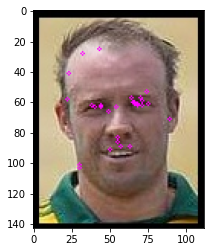

In [30]:
i = np.random.randint(0, len(check_dataset))
image = draw_landmarks(cv2.UMat(np.moveaxis(imgs[i].detach().cpu().numpy(), 0, -1)), 
                       filtered_preds[i].reshape(30, 2))
plt.imshow(image.get());

### Submission

In [31]:
subm = pd.read_csv('../data/sampleSubmission.csv')
subm.iloc[:, 1:] = filtered_preds.astype(np.int32)

In [222]:
subm.to_csv('baseline.csv', index=False)